# Распознавание цифр MNIST на PyTorch
**Тема:** строим свою нейросеть для распознавания рукописных цифр `0..9` из датасета **MNIST**.  

---

## Что мы сделаем за урок
1) Скачаем MNIST через `torchvision`
2) Посмотрим примеры изображений и поймём формат данных
3) Подготовим `DataLoader` (батчи)
4) Напишем модель **MLP** (простая полносвязная сеть)
5) Напишем цикл обучения (**forward → loss → backward → step**)
6) Оценим качество (accuracy + confusion matrix)
7) Сохраним модель и загрузим обратно
8) Протестируем на отдельных картинках

In [1]:
# Если torch/torchvision не установлен (обычно в Colab всё есть):
# !pip install torch torchvision --quiet

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report

import torchvision
from torchvision import datasets, transforms

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("device:", device)

torch: 2.9.0+cpu
torchvision: 0.24.0+cpu
device: cpu


# 1) MNIST: что это?
- Картинки 28×28 (серые)
- Классы 0..9
- Train 60k / Test 10k


# 2) Загрузка данных + transforms
Мы делаем:
- `ToTensor()` → (1, 28, 28), значения 0..1
- `Normalize(mean, std)` → помогает обучению


In [25]:
# transform — это "конвейер" преобразований, который будет применяться к каждой картинке MNIST
transform = transforms.Compose([
    transforms.ToTensor(),  # 1) Переводит картинку в PyTorch Tensor
                            #    + делает нормализацию пикселей из [0..255] → [0..1]
                            #    Пример: 0 → 0.0, 255 → 1.0
    transforms.Normalize((0.1307,), (0.3081,))  # 2) Нормализация: (x - mean) / std
                                                #    mean=0.1307 и std=0.3081 — это статистика MNIST
                                                #    (среднее и стандартное отклонение по всему датасету)
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

print("\ntrain size:", len(train_ds))
print("test size :", len(test_ds))

img0, y0 = train_ds[0]
print("img shape:", img0.shape, "label:", y0)


train size: 60000
test size : 10000
img shape: torch.Size([1, 28, 28]) label: 5


# 3) Визуализация примеров

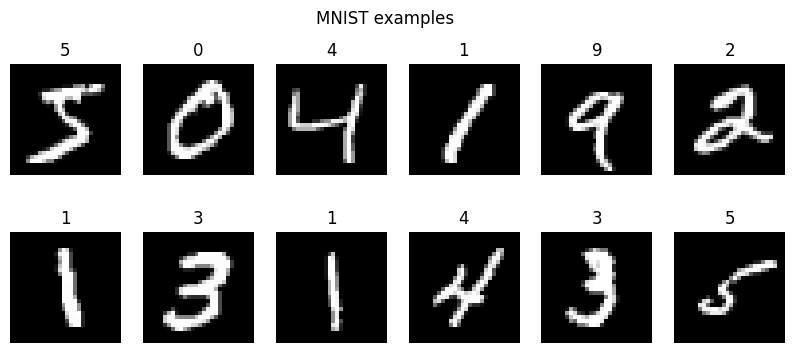

In [4]:
def show_batch(dataset, n=12):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        img, label = dataset[i]
        plt.subplot(2, 6, i+1)
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.title(str(label))
        plt.axis("off")
    plt.suptitle("MNIST examples")
    plt.show()

show_batch(train_ds, 12)

# 4) DataLoader (батчи)

In [5]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False)

Xb, yb = next(iter(train_loader))
print("X batch:", Xb.shape)
print("y batch:", yb.shape)

X batch: torch.Size([128, 1, 28, 28])
y batch: torch.Size([128])


# 5) Модель: MLP
Flatten 28×28 → 784, затем 784→256→128→10.
Выход **logits** (не softmax!).


In [6]:
class MNIST_MLP(nn.Module):
    def __init__(self, hidden1=256, hidden2=128):
        super().__init__()
        self.fc1 = nn.Linear(28*28, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)     # Flatten -> (batch, 784)
        x = F.relu(self.fc1(x))       # (batch, 256)
        x = F.relu(self.fc2(x))       # (batch, 128)
        logits = self.fc3(x)          # (batch, 10)
        return logits

model = MNIST_MLP().to(device)
print(model)
print("params:", sum(p.numel() for p in model.parameters()))

MNIST_MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
params: 235146


# 6) Loss + Optimizer
- CrossEntropyLoss: для 10 классов
- Adam: хороший старт


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(type(criterion).__name__, type(optimizer).__name__)

CrossEntropyLoss Adam


# 7) Train/Eval функции

In [8]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    return total_loss / len(loader.dataset), correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_true = []

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)
        loss = criterion(logits, yb)

        total_loss += loss.item() * Xb.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_true)
    return total_loss / len(loader.dataset), correct / total, y_true, y_pred

# 8) Обучение (несколько эпох)

In [26]:
EPOCHS = 5
history = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    te_loss, te_acc, _, _ = evaluate(model, test_loader, criterion, device)
    history.append((epoch, tr_loss, tr_acc, te_loss, te_acc))
    print(f"epoch={epoch:02d} | train loss={tr_loss:.4f} acc={tr_acc:.4f} | test loss={te_loss:.4f} acc={te_acc:.4f}")

history

epoch=01 | train loss=0.0313 acc=0.9903 | test loss=0.0928 acc=0.9751
epoch=02 | train loss=0.0256 acc=0.9914 | test loss=0.0772 acc=0.9789
epoch=03 | train loss=0.0217 acc=0.9923 | test loss=0.0792 acc=0.9786
epoch=04 | train loss=0.0202 acc=0.9931 | test loss=0.0922 acc=0.9763
epoch=05 | train loss=0.0178 acc=0.9941 | test loss=0.0868 acc=0.9781


[(1, 0.0313440298145016, 0.9903, 0.0928436543226242, 0.9751),
 (2, 0.025636155711114408, 0.9913666666666666, 0.07717780847549438, 0.9789),
 (3, 0.021746956199718018, 0.9922666666666666, 0.07921819305419922, 0.9786),
 (4, 0.02021332325475911, 0.9930666666666667, 0.0922227581858635, 0.9763),
 (5, 0.017835452544751267, 0.9940666666666667, 0.08677850027084351, 0.9781)]

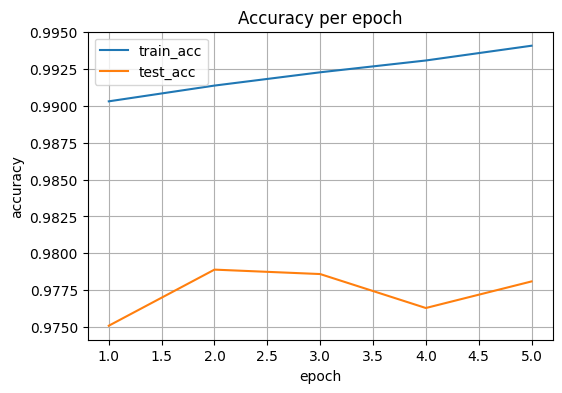

In [27]:
# График accuracy
hist = np.array(history, dtype=float)
epochs = hist[:,0]
train_acc = hist[:,2]
test_acc = hist[:,4]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_acc, label="train_acc")
plt.plot(epochs, test_acc, label="test_acc")
plt.title("Accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(True)
plt.legend()
plt.show()

# 9) Confusion matrix + report

Test accuracy: 0.9781
Report:
               precision    recall  f1-score   support

           0      0.977     0.992     0.984       980
           1      0.987     0.993     0.990      1135
           2      0.982     0.978     0.980      1032
           3      0.979     0.974     0.977      1010
           4      0.980     0.968     0.974       982
           5      0.983     0.973     0.978       892
           6      0.984     0.982     0.983       958
           7      0.977     0.970     0.974      1028
           8      0.986     0.963     0.975       974
           9      0.946     0.985     0.965      1009

    accuracy                          0.978     10000
   macro avg      0.978     0.978     0.978     10000
weighted avg      0.978     0.978     0.978     10000



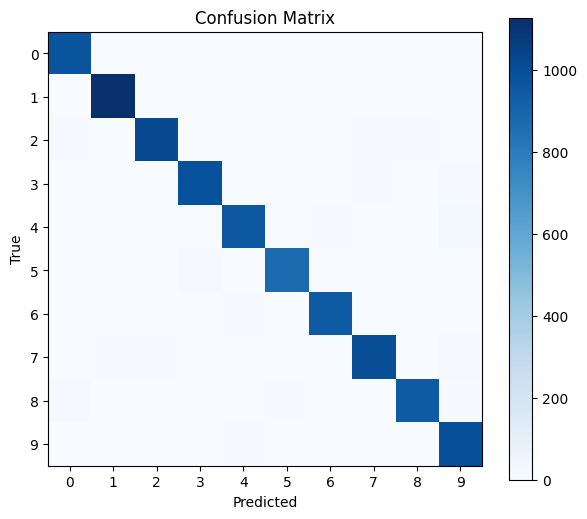

In [28]:
te_loss, te_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)
print("Test accuracy:", te_acc)

cm = confusion_matrix(y_true, y_pred)
print("Report:\n", classification_report(y_true, y_pred, digits=3))

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(10))
plt.yticks(range(10))
plt.show()

# 10) Посмотрим ошибки модели

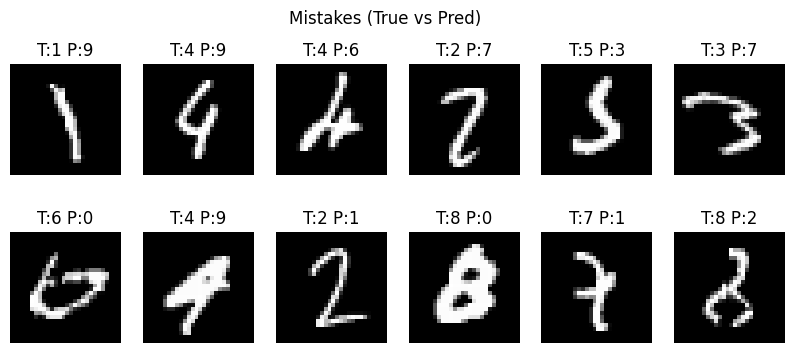

In [29]:
@torch.no_grad()
def show_mistakes(model, dataset, device, n=12):
    model.eval()
    plt.figure(figsize=(10,4))
    shown = 0
    i = 0
    while shown < n and i < len(dataset):
        img, true_label = dataset[i]
        X = img.unsqueeze(0).to(device)
        logits = model(X)
        pred = torch.argmax(logits, dim=1).item()
        if pred != true_label:
            plt.subplot(2, 6, shown+1)
            plt.imshow(img.squeeze(0), cmap="gray")
            plt.title(f"T:{true_label} P:{pred}")
            plt.axis("off")
            shown += 1
        i += 1
    plt.suptitle("Mistakes (True vs Pred)")
    plt.show()

show_mistakes(model, test_ds, device, n=12)

# 11) Save/Load model

In [30]:
MODEL_PATH = "/mnist_mlp_state_dict.pt"
torch.save(model.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

model_loaded = MNIST_MLP().to(device)
model_loaded.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model_loaded.eval()

te_loss2, te_acc2, _, _ = evaluate(model_loaded, test_loader, criterion, device)
print("Loaded model test acc:", te_acc2)

Saved: /mnist_mlp_state_dict.pt
Loaded model test acc: 0.9781


# 12) Предсказание на одной картинке

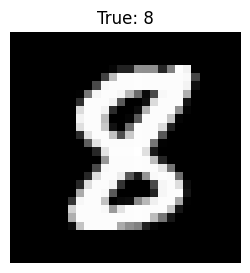

Predicted: 8
Top-3: [8 2 3] [9.9887067e-01 9.0690487e-04 2.1033137e-04]


In [31]:
import random

idx = random.randint(0, len(test_ds)-1)
img, true_label = test_ds[idx]

plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(0), cmap="gray")
plt.title(f"True: {true_label}")
plt.axis("off")
plt.show()

with torch.no_grad():
    X = img.unsqueeze(0).to(device)
    logits = model_loaded(X)
    probs = torch.softmax(logits, dim=1).cpu().numpy().reshape(-1)
    pred = int(np.argmax(probs))

print("Predicted:", pred)
print("Top-3:", np.argsort(probs)[-3:][::-1], np.sort(probs)[-3:][::-1])

## Рисуем сами!

In [32]:
!pip -q install ipycanvas

In [33]:
from google.colab import output
output.enable_custom_widget_manager()

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from ipycanvas import Canvas
import ipywidgets as widgets
from IPython.display import display, clear_output

import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

canvas_size = 280
canvas = Canvas(width=canvas_size, height=canvas_size, sync_image_data=True)

canvas.fill_style = "black"
canvas.fill_rect(0, 0, canvas_size, canvas_size)

canvas.stroke_style = "white"
canvas.line_width = 18
canvas.line_cap = "round"

out = widgets.Output()

btn_clear = widgets.Button(description="🧹 Clear", button_style="warning")
btn_predict = widgets.Button(description="🔮 Predict", button_style="success")

drawing = {"is_drawing": False, "last_x": None, "last_y": None}

def handle_mousedown(x, y):
    drawing["is_drawing"] = True
    drawing["last_x"], drawing["last_y"] = x, y

def handle_mouseup(x, y):
    drawing["is_drawing"] = False
    drawing["last_x"], drawing["last_y"] = None, None

def handle_mousemove(x, y):
    if not drawing["is_drawing"]:
        return
    lx, ly = drawing["last_x"], drawing["last_y"]
    canvas.begin_path()
    canvas.move_to(lx, ly)
    canvas.line_to(x, y)
    canvas.stroke()
    drawing["last_x"], drawing["last_y"] = x, y

canvas.on_mouse_down(handle_mousedown)
canvas.on_mouse_up(handle_mouseup)
canvas.on_mouse_move(handle_mousemove)

def on_clear(_):
    canvas.fill_style = "black"
    canvas.fill_rect(0, 0, canvas_size, canvas_size)
    with out:
        clear_output()

btn_clear.on_click(on_clear)

def on_predict(_):
    img_rgba = canvas.get_image_data()

    img = img_rgba[:, :, 0].astype(np.float32)

    small = img.reshape(28, 10, 28, 10).mean(axis=(1, 3))

    with out:
        clear_output()
        plt.figure(figsize=(3,3))
        plt.imshow(small, cmap="gray")
        plt.title("Your digit (28x28 preview)")
        plt.axis("off")
        plt.show()

    small_uint8 = small.astype(np.uint8)
    X = mnist_transform(small_uint8).unsqueeze(0).to(device)

    model_loaded.eval()
    with torch.no_grad():
        logits = model_loaded(X)
        probs = torch.softmax(logits, dim=1).cpu().numpy().reshape(-1)
        pred = int(np.argmax(probs))

    top3_idx = np.argsort(probs)[-3:][::-1]
    top3_probs = probs[top3_idx]

    print("Predicted:", pred)
    print("Top-3:", top3_idx, np.round(top3_probs, 4))

btn_predict.on_click(on_predict)

display(widgets.HBox([btn_clear, btn_predict]))
display(canvas, out)

Canvas(height=280, sync_image_data=True, width=280)

Output()

Predicted: 9
Top-3: [9 4 8] [9.997e-01 2.000e-04 0.000e+00]
Predicted: 2
Top-3: [2 3 7] [0.8482 0.1415 0.0102]
Predicted: 4
Top-3: [4 2 3] [0.9703 0.0191 0.0088]
Predicted: 4
Top-3: [4 7 9] [0.9739 0.0155 0.0057]
Predicted: 1
Top-3: [1 4 9] [9.875e-01 1.220e-02 2.000e-04]
Predicted: 2
Top-3: [2 3 1] [9.974e-01 2.500e-03 1.000e-04]
Predicted: 9
Top-3: [9 3 8] [0.7941 0.0875 0.0853]
Predicted: 5
Top-3: [5 9 4] [0.551  0.4386 0.0101]


---
# 10 заданий (дополнить код)
Формат: **задание → подсказка → код с пропусками `_____`**


## Задание 1

**Задание:** Соберите transform: ToTensor + Normalize.

**Подсказка:** transforms.Compose([...])


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms._____(),
    transforms.Normalize((_____,), (_____,))
])

transform

## Задание 2

**Задание:** Загрузите MNIST train/test.

**Подсказка:** datasets.MNIST(...)


In [ ]:
from torchvision import datasets

train_ds = datasets.MNIST(root="_____", train=_____, download=_____, transform=_____)
test_ds  = datasets.MNIST(root="_____", train=_____, download=_____, transform=_____)

print(len(train_ds), len(test_ds))

## Задание 3

**Задание:** Сделайте DataLoader.

**Подсказка:** DataLoader(dataset, batch_size, shuffle)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=_____, shuffle=_____)
test_loader  = DataLoader(test_ds, batch_size=_____, shuffle=_____)

Xb, yb = next(iter(train_loader))
print(Xb.shape, yb.shape)

## Задание 4

**Задание:** Допишите forward (Flatten + ReLU).

**Подсказка:** x.view + F.relu


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StudentMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(_____, _____)
        self.fc2 = nn.Linear(_____, _____)
        self.fc3 = nn.Linear(_____, _____)

    def forward(self, x):
        x = x.view(x.size(0), _____)
        x = F.relu(self.fc1(_____))
        x = F.relu(self.fc2(_____))
        logits = self.fc3(_____)
        return logits

m = StudentMLP(); print(m)

## Задание 5

**Задание:** Создайте criterion + optimizer.

**Подсказка:** CrossEntropyLoss + Adam


In [ ]:
import torch
import torch.nn as nn

model = StudentMLP()
criterion = nn._____()
optimizer = torch.optim._____(model.parameters(), lr=_____)

print(type(criterion).__name__, type(optimizer).__name__)

## Задание 6

**Задание:** Сделайте один шаг обучения на батче.

**Подсказка:** zero_grad/backward/step


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StudentMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Xb, yb = next(iter(train_loader))
Xb = Xb.to(_____)
yb = yb.to(_____)

logits = model(_____)
loss = criterion(_____, _____)

optimizer._____()
loss._____()
optimizer._____()

print("loss:", loss.item())

## Задание 7

**Задание:** Посчитайте accuracy батча.

**Подсказка:** argmax(dim=1)


In [ ]:
import torch

preds = torch.argmax(_____, dim=_____)
acc = (preds == _____).float().mean().item()
print("batch acc:", acc)

## Задание 8

**Задание:** Напишите evaluate_student: model.eval() + no_grad.

**Подсказка:** верните accuracy на test_loader


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import torch

@torch.no_grad()
def evaluate_student(model, loader, device):
    model._____()
    all_preds, all_true = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(_____)
        preds = torch.argmax(_____, dim=1).cpu().numpy()
        all_preds.append(_____)
        all_true.append(yb.numpy())
    y_pred = np.concatenate(_____)
    y_true = np.concatenate(_____)
    return accuracy_score(_____, _____)

acc = evaluate_student(model, test_loader, device)
print("test acc:", acc)

## Задание 9

**Задание:** Сохраните и загрузите state_dict.

**Подсказка:** torch.save + load_state_dict


In [ ]:
import torch

path = "/tmp_mnist.pt"
torch.save(model._____, path)

model2 = StudentMLP().to(device)
model2.load_state_dict(torch.load(_____, map_location=_____))
model2.eval()
print("loaded ok")

## Задание 10

**Задание:** Выведите 8 ошибок модели на тесте.

**Подсказка:** рисуем картинки и подписи T/P


In [ ]:
import matplotlib.pyplot as plt
import torch

model.eval()
shown = 0
i = 0

plt.figure(figsize=(10,3))
while shown < _____ and i < len(test_ds):
    img, true_label = test_ds[i]
    X = img.unsqueeze(0).to(_____)
    with torch.no_grad():
        logits = model(_____)
        pred = torch.argmax(_____, dim=1).item()
    if pred != true_label:
        plt.subplot(1, 8, shown+1)
        plt.imshow(img.squeeze(0), cmap="_____")
        plt.title(f"T:{true_label}\nP:{pred}")
        plt.axis("off")
        shown += 1
    i += 1

plt.show()